# <font style="color:rgb(50,120,229)">Object Tracking using Meanshift and CAMshift</font>

# <font style="color:rgb(50,120,229)">Overview</font>

In the previous chapter, we saw how tracking using a Kalman filter works. In this chapter, we will pose Object Tracking as a Mode-seeking problem and use an algorithm called Meanshift to track the object. It is very intuitive and performs well for real-time tracking of non-rigid objects. It is robust to occlusion, clutter and small variations in scale. We will perform face tracking as an example application. 

We will discuss another algorithm for object tracking called CAMshift which use Meanshift at its core and see how it improves tracking over Meanshift.

# <font style="color:rgb(50,120,229)">Object Tracking using Meanshift</font>

We will discuss Object Tracking using Meanshift algorithm. 

## <font style="color:rgb(50,120,229)">What is Meanshift?</font>

Meanshift is a non-parametric approach for finding the mode of a set of points. In other words, it finds the maxima of a density function. It was first presented by Fukunaga and Hostetler in 1975 in their [paper](http://ieeexplore.ieee.org/document/1055330/). Variations of meanshift algorithm are used for applications like Image segmentation and edge preserving filtering. 

### <font style="color:rgb(50,120,229)">A simple example</font>

Consider the scatter plot of a set of points shown below. Meanshift uses an iterative approach to find the center of mass or the region with highest density. In the figure below, the red star is the point around which the mean will be calculated and the red circle indicates the region being evaluated in the present iteration. If we think of the points having some mass, then the center of mass will not be the same as the center of the circle. We are interested in this center of mass for finding the mode of the data. The green star indicates the center of mass for the region marked by the red circle. Let’s see how it works.

We make a random estimate for the red star to begin. Assuming all points have same weight, the center of mass is calculated, represented by the green star. The center of the circle is shifted to the center of mass at the start of the next iteration. The same process is repeated till the center of mass ( green star ) does not move with respect to the actual center ( red star ). The whole process involves calculating and shifting the mean of a set of data points and thus it is called Meanshift. The black arrow signifies the direction and amount by which the mean should be shifted between iterations and is called the meanshift vector.



| <center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-meanShift1stteration.png" width=500/></center> | <center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-meanShift2ndIteration.png" width=500/></center> | 
| -------- | -------- | 
| <center>1st Iteration</center>     | <center>2nd Iteration</center>     |
| <center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-meanShift3rdIteration.png" width=500/></center> | <center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-meanShiftConvergence.png" width=500/></center> | 
| <center>3rd Iteration</center>     | <center>Convergence</center>     |

<center>Illustration of the meanshift process. Red star - center of region of interest for current iteration. Green star - center of mass for the region in the current iteration.</center>

&nbsp;
The radius of the circle, also called the window size, is the most important parameter. The estimated mode depends on this parameter. Too small window will generate local maxima, not global. Too large will not let the algorithm find the true maxima. If there are more than one mode, they will be merged. To solve this problem, the window size needs to be changed adaptively which is done in another algorithm called CAMshift - Continuously Adaptive Meanshift, which we will discuss later.

### <font style="color:rgb(50,120,229)">The equations</font>

Coming to the mathematical details of the above process, for the center of window located at $x$, the center of mass is calculated using the below mentioned formula : 
$$
m(x) = \frac{\sum_i{K(x − x_i)}x_i}{\sum_i{K(x − x_i)}}
$$

Where,

K is the kernel which decides the window size and how the weights of different points will be accumulated,

$x_i$ are the neighboring points,

$m(x)$ is the center of mass,



In the above example, we had used a uniform kernel, which means that all points contribute equally to the center of mass, for a given window size $d$. $K(x)$ in this case is given by : 

$$
K_U(x)  = \begin{cases} 1,& \text{if } ||x|| \le d \\ 0, & \text{if } ||x|| > d \end{cases}
$$

A better kernel will be the one which gives more importance to the points which are closer to $x$ and slowly decays as we go farther. This is achieved by using a gaussian kernel ( $K_G$ ) or an epanechnikov kernel ( $K_E$ ) which are given by :


$$
K_G(x)  = \begin{cases} e^−{\frac{||x||^2}{d^2}},& \text{if } ||x|| \le d \\ 0, & \text{if } ||x|| > d \end{cases}
$$
$$
K_E(x)  = \begin{cases} 1 − \frac{||x||^2}{d^2},& \text{if } ||x|| \le d \\ 0, & \text{if } ||x|| > d \end{cases}
$$

### <font style="color:rgb(50,120,229)">What about Object tracking</font>

Now that we have seen how Meanshift finds the maxima of a density function, we want to apply this to perform Object tracking. For that, we have to model object tracking as a mode seeking problem. This can be done as follows : 

1. Find the color histogram of the object of interest.

2. For every new frame, find a likelihood image ( which is similar to a density function ), whose pixels indicate how similar they are with the color distribution of the object of interest. This likelihood image can be obtained by histogram backprojection which is discussed in the next section. 

3. Use Meanshift to find the maxima of this likelihood image cum density function, which gives the position of the object in the new frame.

## <font style="color:rgb(50,120,229)">What is Histogram Backprojection?</font>

Histogram backprojection is a way of finding the similarity between two images. It can be vaguely defined as a method of re-applying a pre-calculated histogram to a new image to find the similarity between the color distribution of the new image and the object of interest. Say, we have a histogram of the object of interest given by **H**. Then, for every pixel in the new image, it finds the bin in **H** that it should belong to and creates a new image with the pixel value being the value of bin count. 

For example, we want to find the orange colored ball in the image shown below. Suppose, we have computed a histogram with orange color ball, since it is our object of interest. The histogram will have high values in bins having orange color and very low values in bins for other colors. Now, in the back projected image, the pixels belonging to the orange ball will have very high values and other pixels will have lower values as shown below.

In this way, it creates a likelihood image where each pixel represents the probability of that pixel having the same color distribution as that of the object.



| <center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-newFrame.jpg" width=500/></center> | <center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-backProjectedImage.jpg" width=500/></center> | 
| -------- | -------- | 
| <center>New Frame</center>     | <center>Back Projected Image</center>     | 


## <font style="color:rgb(50,120,229)">Object Tracking using Meanshift in OpenCV</font>

We will describe how to perform object tracking, specifically faces using the concepts learned till now. A step by step approach is given below :

### <font style="color:rgb(50,120,229)">Step 1 : Find the histogram of the face region</font>

First, we detect the face using Dlib’s face detector. Then compute the histogram of the face region. HSV color space is an intuitive color space as it represents color much like humans perceive it. Thus we use this to calculate the histogram of the face region. We use the Hue Channel only. However, both the H and S channels can be used. We use the [`calcHist()`](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/histograms.html#calchist) OpenCV function to compute the histogram and normalize the histogram to have values in the range [0, 255]. It should be kept in mind that color information is very sensitive to lighting variations.

### <font style="color:rgb(50,120,229)">Step 2 : Find Back Projected image</font>

For every new frame, convert it to the same color space used for finding the histogram. Find the back projected image, $BP$ using the [`calcBackProject()`](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/histograms.html#calcbackproject) OpenCV function.

### <font style="color:rgb(50,120,229)">Step 3 : Apply Meanshift</font>

Use meanshift to find the maxima in the back projected image in the neighborhood of the old position. We use [`meanShift()`](http://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#meanshift) OpenCV function to get the new position. As explained in the earlier section, the algorithm finds the mode of the back projected image which is a confidence map of similarity between the color distribution of the object and the new image. The first few iterations for a particular frame of the meanshift process are shown in the figure below.

<table>
    <tr>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-meanshiftIter1.jpg" width=500/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-meanshiftIter2.jpg" width=500/></center></th>
    </tr>
    <tr>
        <td><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-meanshiftIter3.jpg" width=500/></center></td>
        <td><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-meanshiftIter4.jpg" width=500/></center></td>
    </tr>
    <tr>
        <td><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-meanshiftIter5.jpg" width=500/></center></td>
        <td><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-meanshiftIter6.jpg" width=500/></center></td>
    </tr>
    <tr>
        <td colspan="2"><center>Showing the iterations of meanshift tracking.</center> 
            <center>Observe how the tracking window gradually moves to align with the face.</center></td>
    </tr>
</table>

## <font style="color:rgb(50,120,229)">Meanshift Tracking Code</font>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

Initialize the video feed and declare variables. Read a frame and find the face region using Dlib facial detector. Also convert the dlib rectangle to OpenCV rect.

In [3]:
filename = DATA_PATH + "videos/face1.mp4"
cap = cv2.VideoCapture(filename)

# Read a frame and find the face region using dlib
ret,frame = cap.read()

# Detect faces in the image
faceCascade = cv2.CascadeClassifier(DATA_PATH + 'models/haarcascade_frontalface_default.xml')

frameGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
faces = faceCascade.detectMultiScale(frameGray,1.3,5)
x,y,w,h = faces[0]

currWindow = (x,y,w,h)

Get the face region and convert to HSV color space. Use the inRange function to get rid of spurious noise and create a mask which will be used for computing the histogram.



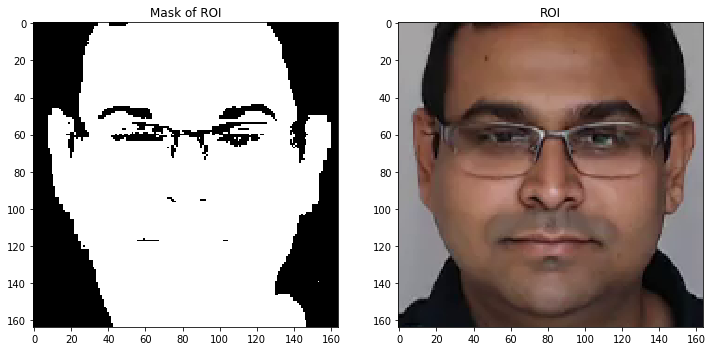

In [4]:
# get the face region from the frame
roiObject = frame[y:y+h,x:x+w]

hsvObject =  cv2.cvtColor(roiObject, cv2.COLOR_BGR2HSV)

# Get the mask for calculating histogram of the object and 
# also remove noise
mask = cv2.inRange(hsvObject, np.array((0., 50., 50.)), 
                  np.array((180.,255.,255.)))

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.title("Mask of ROI")
plt.imshow(mask)
plt.subplot(1,2,2)
plt.title("ROI")
plt.imshow(roiObject[:,:,::-1])
plt.show()

We use 180 bins for each hue value. Use calcHist function to compute the histogram. We also normalize the histogram values to lie between and 255.

In [5]:
# Find the histogram and normalize it to have values 
# between 0 to 255
histObject = cv2.calcHist([hsvObject], [0],
                        mask, [180], [0,180])           
cv2.normalize(histObject, histObject, 0, 
              255, cv2.NORM_MINMAX);

Read a frame and convert to HSV color space and find the back projected image using the histogram calculated earlier.



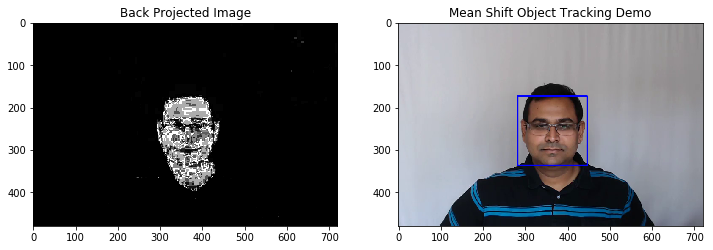

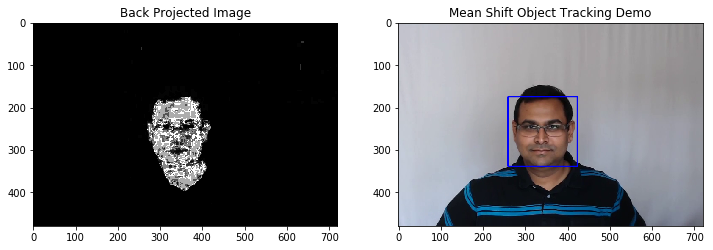

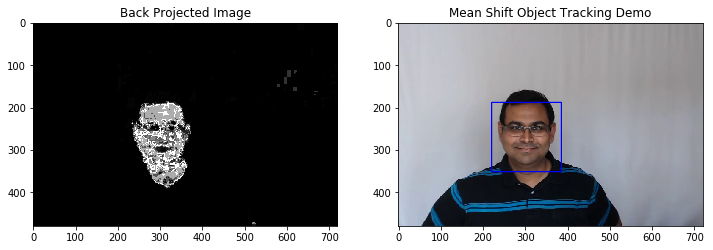

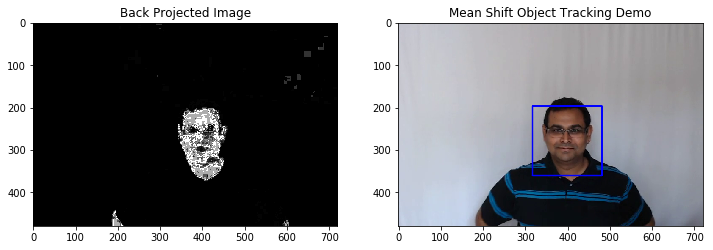

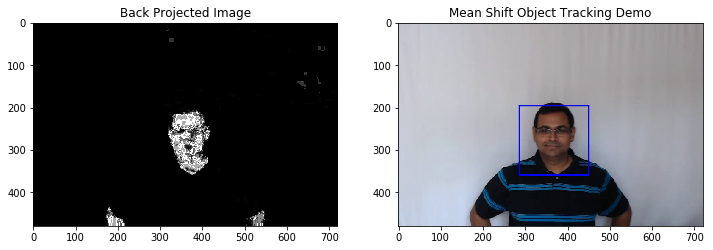

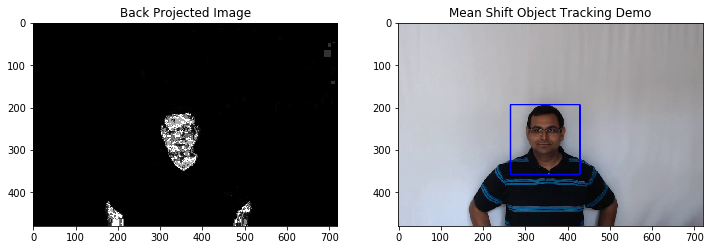

In [6]:
# Setup the termination criteria, either 10 iterations or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

# We will process only first 5 frames
count = 0
while(1):
    ret , frame = cap.read()
    if ret == True:
        # Convert to hsv color space
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # find the back projected image with the histogram obtained earlier
        backProjectImage = cv2.calcBackProject([hsv], [0], histObject, [0,180], 1)

        # Compute the new window using mean shift in the present frame
        ret, currWindow = cv2.meanShift(backProjectImage, currWindow, term_crit)

        # Display the frame with the tracked location of face
        x,y,w,h = currWindow
        frameClone = frame.copy()

        if count % 20 == 0:
            plt.figure(figsize=(12,12))
            plt.subplot(1,2,1)
            plt.imshow(backProjectImage)
            plt.title("Back Projected Image")
            cv2.rectangle(frameClone, (x,y), (x+w,y+h), (255,0,0), 2, cv2.LINE_AA)
            plt.subplot(1,2,2)
            plt.imshow(frameClone[:,:,::-1])
            plt.title('Mean Shift Object Tracking Demo')
            plt.show()
    else:
        break
    count += 1
    if count > 100:
        break

In [7]:
cap.release()

## <font style="color:rgb(50,120,229)">Discussion on performance</font>

Given below are some frames with the tracked locations of the object shown using rectangles. 

<table>
    <tr>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-trackingResult1.jpg"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-TrackingResult2.jpg"/></center></th>
    </tr>
    <tr>
        <td><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-trackingResult3.jpg"/></center></td>
        <td><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-trackingEsult4.jpg"/></center></td>
    </tr>
    <tr>
        <td colspan="2"><center>Figure showing the results of tracking.</center> 
            <center>The first row shows correct tracking and the second row shows failure cases.</center></td>
    </tr>
</table>



The first row shows that the tracker performs well if there is lateral movement with respect to the camera. But when there is change in the scale of the object, it fails to detect the object as it works on the same window size. In the first frame on second row, the tracker detects the face but the window size does not match the face. We will see how it can be improved in the next section.


# <font style="color:rgb(50,120,229)">Object Tracking using CAMshift</font>

CAMshift is the short form for Continuously Adaptive Meanshift.  As we saw in the previous section that since Meanshift uses the same window size, it fails to detect the object if the scale changes. CAMshift tries to tackle this problem by using varying window size for applying meanshift. It was developed by Gary Bradski and [published](http://opencv.jp/opencv-1.0.0_org/docs/papers/camshift.pdf) in 1998. The CAMshift algorithm works as follows : 

1. Specify the initial search window of height $h$ and width $w$ centered at $(x_c,y_c)$.

2. Use Meanshift to get the updated location of $(x_c,y_c)$ and store the zeroth moment which is given by :

$$
M_{00} = \sum_{x,y}BP(x,y)
$$

It is the sum of all pixels in the window of the back projected image.

3. Move the window center to the new center of mass and increase the width of the window to be $w = 2\sqrt{\frac{M_{00}}{256}}$ and height to be $h=1.2w$

4. Repeat steps 2 and 3 until convergence.

The orientation of the object window is also calculated using second order moments. This can be used to find the head roll, length and width of the face. The derivation of orientation from second order moments of the back projected image can be found in the [paper](http://opencv.jp/opencv-1.0.0_org/docs/papers/camshift.pdf).

## <font style="color:rgb(50,120,229)">Object Tracking using CAMshift in OpenCV</font>

We follow the steps 1 and 2 used for Object tracking with Meanshift. For the third step, after we have found the back projected image, we use [`CamShift()`](https://docs.opencv.org/4.1.0/dc/d6b/group__video__track.html#gaef2bd39c8356f423124f1fe7c44d54a1) OpenCV function to track the position of the object in the new image. 

`Camshift()` finds an object center using meanshift and then adjusts the window size. In addition, it finds the optimal rotation of the object. The function returns the rotated rectangle structure that includes the object position, size, and orientation. In the figure shown below, the blue rectangle shows the current window of interest and green rectangle shows the rotated rectangle.

<table>
    <tr>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-camshiftIter1.jpg"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-camshiftIter2.jpg"/></center></th>
    </tr>
    <tr>
        <td><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-camshiftIter3.jpg"/></center></td>
        <td><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-camshiftIter4.jpg"/></center></td>
    </tr>
    <tr>
        <td colspan="2"><center>Illustration of adaptive window size in CAMshift</center></td>
    </tr>
</table>

### <font style="color:rgb(50,120,229)">Improvements over Meanshift</font>

We can see the improvements of using an adaptive window size as done by CAMshift. The failure cases of meanshift are properly tracked in the case of CAMshift.

<table>
    <tr>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-camshift1.jpg"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-camShift2.jpg"/></center></th>
    </tr>
    <tr>
        <td><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-camShift3.jpg"/></center></td>
        <td><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w8-m3-camShift4.jpg"/></center></td>
    </tr>
</table>

## <font style="color:rgb(50,120,229)">CAMshift Tracking Code</font>

Initialize the video feed and declare variables. Read a frame and find the face region using Dlib facial detector. Also convert the dlib rectangle to OpenCV rect.

In [8]:
filename = DATA_PATH + "videos/face1.mp4"
cap = cv2.VideoCapture(filename)

# Read a frame and find the face region using dlib
ret,frame = cap.read()

# Detect faces in the image
faceCascade = cv2.CascadeClassifier(DATA_PATH + 'models/haarcascade_frontalface_default.xml')

frameGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
faces = faceCascade.detectMultiScale(frameGray,1.3,5)
x,y,w,h = faces[0]
currWindow = (x,y,w,h)

Get the face region and convert to HSV color space. Use the inRange function to get rid of spurious noise and create a mask which will be used for computing the histogram.



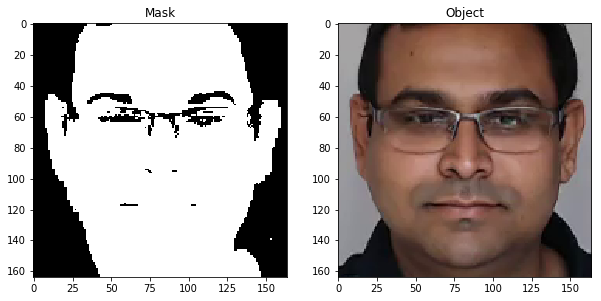

In [9]:
# get the face region from the frame
roiObject = frame[y:y+h,x:x+w]
face_height,face_width = roiObject.shape[:2]

hsvObject =  cv2.cvtColor(roiObject, cv2.COLOR_BGR2HSV)

# Get the mask for calculating histogram of the object and also remove noise
mask = cv2.inRange(hsvObject, np.array((0., 50., 50.)), np.array((180.,255.,255.)))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(mask)
plt.title("Mask")
plt.subplot(1,2,2)
plt.imshow(roiObject[:,:,::-1])
plt.title("Object")
plt.show()

We use 180 bins for each hue value. Use calcHist function to compute the histogram. We also normalize the histogram values to lie between and 255.



In [10]:
# Find the histogram and normalize it to have values between 
# 0 to 255
histObject = cv2.calcHist([hsvObject], [0],
                         mask, [180], [0,180])           
cv2.normalize(histObject, histObject,
             0, 255, cv2.NORM_MINMAX);

Read a frame and convert to HSV color space and find the back projected image using the histogram calculated earlier.



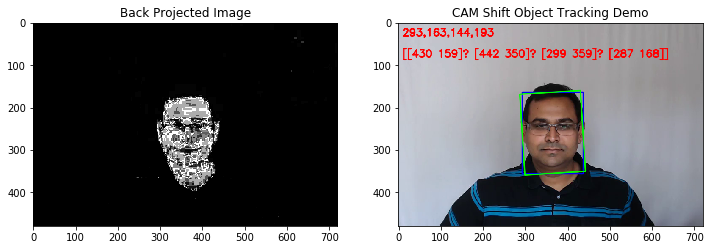

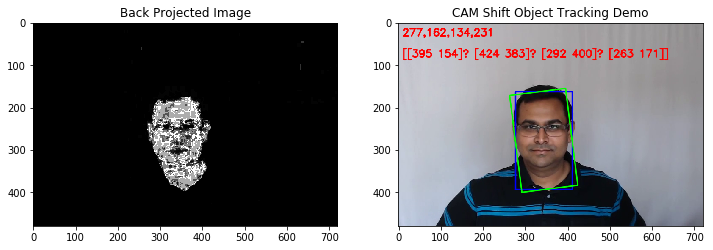

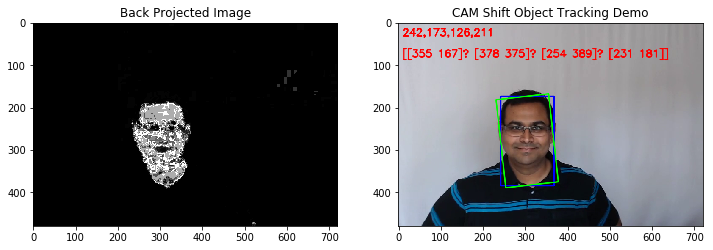

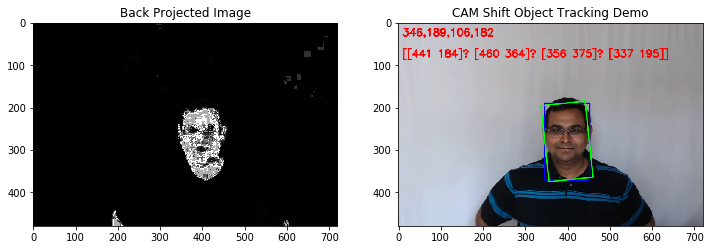

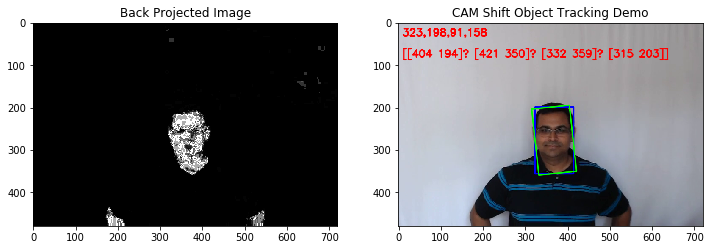

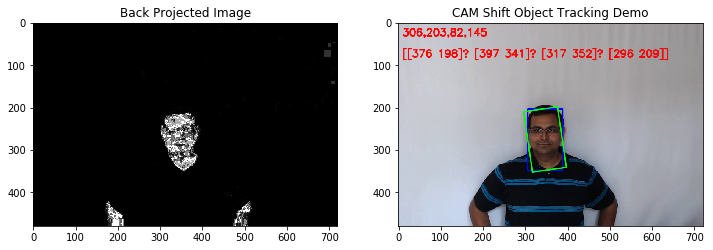

In [11]:
# Setup the termination criteria, either 10 iterations or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
# We will display only first 5 frames
count = 0
i=0
while(1):
    ret, frame = cap.read()
    if ret == True:
        # Convert to hsv color space
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # find the back projected image with the histogram obtained earlier
        backProjectImage = cv2.calcBackProject([hsv], [0], histObject, [0,180], 1)



        # Compute the new window using CAM shift in the present frame
        rotatedWindow, currWindow = cv2.CamShift(backProjectImage, currWindow, term_crit)

        # Get the window used by mean shift
        x,y,w,h = currWindow

        # Get the rotatedWindow vertices
        rotatedWindow = cv2.boxPoints(rotatedWindow)
        rotatedWindow = np.int0(rotatedWindow)
        frameClone = frame.copy()

        # Display the current window used for mean shift
        cv2.rectangle(frameClone, (x,y), (x+w,y+h), (255, 0, 0), 2, cv2.LINE_AA)

        # Display the rotated rectangle with the orientation information
        frameClone = cv2.polylines(frameClone, [rotatedWindow], True, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frameClone, "{},{},{},{}".format(x,y,w,h), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(frameClone, "{}".format(rotatedWindow), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, .8, (0, 0, 255), 2, cv2.LINE_AA)

        if count % 20 == 0:
            plt.figure(figsize=(12,12))
            plt.subplot(1,2,1)
            plt.imshow(backProjectImage)
            plt.title("Back Projected Image")
            plt.subplot(1,2,2)
            plt.imshow(frameClone[:,:,::-1])
            plt.title('CAM Shift Object Tracking Demo')
            plt.show()

        i+=1
    else:
        break
    count += 1
    if count > 100:
        break

In [12]:
cap.release()

# <font style="color:rgb(50,120,229)">References and Further Reading</font>

1. [https://en.wikipedia.org/wiki/Mean_shift](https://en.wikipedia.org/wiki/Mean_shift)

2. [http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)